In [1]:
%load_ext autoreload
%autoreload 2
from common import *
from envs import *
from copy import deepcopy
from RiskAverseMCTS import RiskAverseMCTS
from RiskAverseSparseSampler import RiskAverseSparseSampler
from RiskAverseMarkovAgent import RiskAverseMarkovAgent
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

In [3]:
N_alpha = 7
N_params = 2
N_rollouts = 500
N_iter = 400
alpha_vals = np.linspace(0.25,1.0,N_alpha)
param_vals = np.arange(N_params)
mdps = [NPullBandit(param=p) for p in param_vals]
belief = [0.6, 0.4] #np.ones(N_params, dtype='float')/N_params

In [436]:
import cProfile
agent = RiskAverseMarkovAgent(mdps, belief, max_depth=4, 
                               alpha=1, max_r=2., n_iter=750, K=5, n_burn_in=0, c=1  )
env = Env(mdps[0], agent)
stats = cProfile.run("agent.plan(0)")
#stats = env.rollout(n_rollouts=10, render=False)
#print(np.array(stats.trajectories)[:,:,1])

         9480366 function calls (8992127 primitive calls) in 19.185 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   19.185   19.185 <string>:1(<module>)
        1    0.047    0.047   19.185   19.185 RiskAverseMarkovAgent.py:107(SparseSampling)
      750    0.002    0.000    0.002    0.000 RiskAverseMarkovAgent.py:139(<listcomp>)
      749    0.020    0.000    1.458    0.002 RiskAverseMarkovAgent.py:150(update_adversarial_belief)
307500/7500    0.993    0.000   17.607    0.002 RiskAverseMarkovAgent.py:185(estimateV)
187500/7500    2.951    0.000   17.527    0.002 RiskAverseMarkovAgent.py:211(estimateQ)
   172096    0.149    0.000    1.259    0.000 RiskAverseMarkovAgent.py:239(sample_rollout_action)
   187500    0.351    0.000    1.656    0.000 RiskAverseMarkovAgent.py:268(greedy_action)
        1    0.000    0.000    0.000    0.000 RiskAverseMarkovAgent.py:61(reset_tree)
        1    0.000    0.

We perform a rollout on every MDP with every $\alpha$ value

In [439]:
rewards = np.zeros([N_alpha, N_params, N_rollouts])
for i, alpha in enumerate(alpha_vals):
#     agent = RiskAverseMCTS(mdps, belief, max_depth=4, 
#                            alpha=alpha, max_r=1., n_iter=500, K=50, n_burn_in=0 )
    agent = RiskAverseSparseSampler(mdps, belief, max_depth=4, 
                               alpha=alpha, max_r=2., n_iter=750, K=5, n_burn_in=0, c=1  )
    for j, mdp in enumerate(mdps):
        agent.reset_belief()
        env = Env(mdp, agent)
        stats = env.rollout(n_rollouts=N_rollouts, render=False)
        rewards[i,j,:] = stats.total_rewards
        print("\r a =",alpha,"\tmdp",j,"reward:", np.mean(stats.total_rewards), end='', flush='True')
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

 a = 0.5 	avg_r: 0.5418 	var_r: 0.00186624
 a = 0.625 	avg_r: 0.5592 	var_r: 0.00088804
 a = 0.75 	avg_r: 0.4783 	var_r: 0.00356409
 a = 0.875 	avg_r: 0.6754 	var_r: 0.03334276
 a = 1.0 	avg_r: 0.6335 	var_r: 0.23377225


In [535]:
mkv_rewards = np.zeros([N_alpha, N_params, N_rollouts])
for i, alpha in enumerate(alpha_vals):
#     agent = RiskAverseMCTS(mdps, belief, max_depth=4, 
#                            alpha=alpha, max_r=1., n_iter=500, K=50, n_burn_in=0 )
    mkv_agent = RiskAverseMarkovAgent(mdps, belief, max_depth=4, 
                               alpha=alpha, max_r=2., n_iter=750, K=5, n_burn_in=0, c=1  )
    for j, mdp in enumerate(mdps):
        mkv_agent.reset_belief()
        env = Env(mdp, mkv_agent)
        mkv_stats = env.rollout(n_rollouts=N_rollouts, render=False)
        mkv_rewards[i,j,:] = mkv_stats.total_rewards
        print("\r a =",alpha,"\tmdp",j,"reward:", np.mean(mkv_stats.total_rewards), end='', flush='True')
    print("\r a =",alpha,"\tavg_r:",np.mean(mkv_rewards[i,:,:]), "\tvar_r:", np.var(np.mean(mkv_rewards[i,:,:], axis=1)), flush='True')

 a = 0.25 	avg_r: -0.0252 	var_r: 0.08248384
 a = 0.375 	avg_r: -0.0424 	var_r: 0.06728836
 a = 0.5 	avg_r: -0.0048 	var_r: 0.06853924
 a = 0.625 	avg_r: -0.0171 	var_r: 0.12823561
 a = 0.75 	avg_r: -0.0141 	var_r: 0.07458361
 a = 0.875 	avg_r: -0.017 	var_r: 0.0841
 a = 1.0 	avg_r: -0.0187 	var_r: 0.07327849


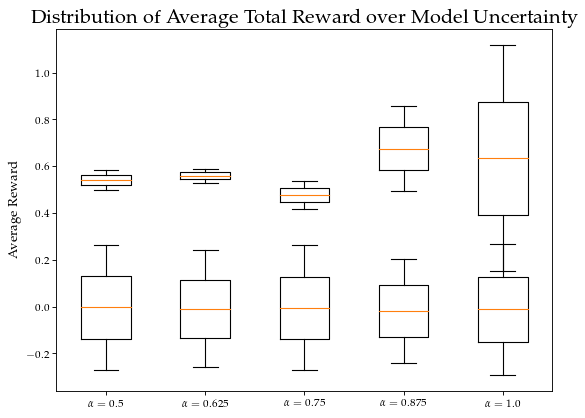

In [440]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
labels = [r"$\alpha="+str(a)+r"$" for a in alpha_vals]
# mean_rewards = np.mean(rewards, axis=2)
# std_mean_reward = np.std(rewards, axis=2)/sqrt(N_rollouts)
plt.boxplot(np.mean(rewards[:,:,:], axis=2).T, labels=labels)
plt.boxplot(np.mean(mkv_rewards[:,:,:], axis=2).T, labels=labels)
plt.title("Distribution of Average Total Reward over Model Uncertainty", fontsize=18)
plt.ylabel("Average Reward", fontsize=12)
#plt.xlabel("Avg Total Cost under Model", fontsize=16)
plt.legend(fontsize=16)
#plt.savefig('performance_gridworld_spreads_5.pdf')
plt.show()

# Convergence plots

## RAMCP

In [4]:
br_belief_curves = []
avg_belief_curves = []
agent_value_curves = []
adv_value_curves = []
model_value_curves = []
Q_val_curves = []
final_q_vals = []
final_n_vals = []
for i, alpha in enumerate(alpha_vals):
    agent = RiskAverseSparseSampler(mdps, belief, max_depth=4, 
                               alpha=alpha, n_iter=250, K=1, n_burn_in=0, c=1  )
    s0 = mdps[0].reset()
    agent.plan(s0)
    br_belief_curves.append(deepcopy(agent.adv_brs))
    avg_belief_curves.append(deepcopy(agent.adv_avg))
    agent_value_curves.append(deepcopy(agent.agent_est_value))
    adv_value_curves.append(deepcopy(agent.adv_est_value))
    Q_val_curves.append(deepcopy(agent.agent_Q_vals))
    model_value_curves.append(deepcopy(agent.model_value_history))
    final_q_vals.append( [agent.Qha[(s0,a)] for a in mdps[0].action_space(s0)] )
    final_n_vals.append( [agent.Wha_br[(s0,a)] for a in mdps[0].action_space(s0)] )

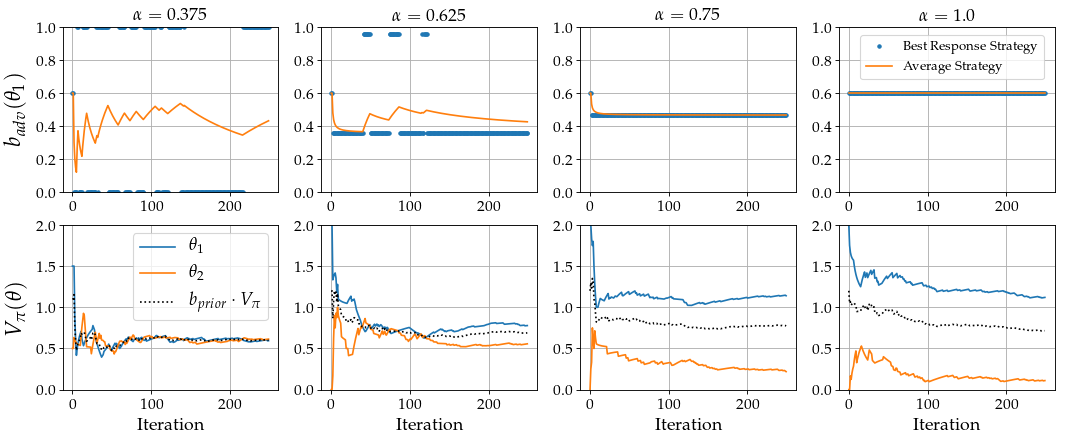

In [5]:
# belief_np = np.array(belief_curves)
br_belief_np = np.array(br_belief_curves)
avg_belief_np = np.array(avg_belief_curves)
np_model_vals = np.array(model_value_curves)
performance_on_bavg = np.sum(np_model_vals*avg_belief_np, axis=2)
performance_on_prior = np.sum( np.reshape(belief, [1,1,-1])*np_model_vals, axis=2 ) #belief[0]*np_model_vals[:,:,0] + belief[1]*np_model_vals[:,:,1]

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
for i,alpha_i in enumerate([1, 3, 4, 6]):
    plt.subplot(2,4,i+1)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.plot(br_belief_np[alpha_i,:,0], label='Best Response Strategy', linestyle='None', marker='.')
    plt.plot(avg_belief_np[alpha_i,:,0], label='Average Strategy')
    #plt.plot(belief_np[alpha_i,:,0], label='Mixed strategy', linestyle=':')
    
    if i == 0:
        plt.ylabel(r"$b_{adv}(\theta_1)$", fontsize=20)
    plt.title(r"$\alpha ="+str(alpha_vals[alpha_i])+r"$", fontsize=16)
    if i == 3:
        plt.legend(fontsize=12, bbox_to_anchor=(0.95, 0.95), loc=1,
                   ncol=1, borderaxespad=0.)
    plt.ylim([0,1])
    plt.grid(True)
    
    plt.subplot(2,4,4+i+1)
    plt.tick_params(axis='both', which='major', labelsize=14)
    for j in range(N_params):
        plt.plot(np_model_vals[alpha_i,:,j], label=r"$\theta_" + str(j+1) + r"$")
    plt.plot(performance_on_prior[alpha_i,:], label=r"$b_{prior} \cdot V_\pi$", linestyle=':', color='k')
    #plt.plot(performance_on_bavg[alpha_i,:], label=r"$\bar{b}_{adv} \cdot V_\pi$")
    
    if i == 0:
        plt.ylabel(r"$V_\pi(\theta)$", fontsize=20)
    if i == 0:
        plt.legend(fontsize=16, bbox_to_anchor=(0.95, 0.95), loc=1,
                   ncol=1, borderaxespad=0.)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylim([0,2])
    plt.grid(True)

#plt.savefig('npull_bandit_convergence.pdf')
plt.show()

## RAMCP with UCT
Experimental, convergence not proven theoretically

In [512]:
uct_belief_curves = []
uct_br_belief_curves = []
uct_avg_belief_curves = []
uct_agent_value_curves = []
uct_adv_value_curves = []
uct_model_value_curves = []
uct_Q_val_curves = []
uct_final_q_vals = []
uct_final_n_vals = []
for i, alpha in enumerate(alpha_vals):
    uct_agent = RiskAverseMCTS(mdps, belief, max_depth=4, 
                               alpha=alpha, max_r=2., n_iter=1000, K=16, n_burn_in=0  )
    s0 = mdps[0].reset()
    uct_agent.plan(s0)
    uct_belief_curves.append(deepcopy(uct_agent.adv_dists))
    uct_br_belief_curves.append(deepcopy(uct_agent.adv_brs))
    uct_avg_belief_curves.append(deepcopy(uct_agent.adv_avg))
    uct_agent_value_curves.append(deepcopy(uct_agent.agent_est_value))
    uct_adv_value_curves.append(deepcopy(uct_agent.adv_est_value))
    uct_Q_val_curves.append(deepcopy(uct_agent.agent_Q_vals))
    uct_model_value_curves.append(deepcopy(uct_agent.model_value_history))
    uct_final_q_vals.append( [uct_agent.Qha[(s0,a)] for a in mdps[0].action_space(s0)] )
    uct_final_n_vals.append( [uct_agent.Wha[(s0,a)] for a in mdps[0].action_space(s0)] )

## RMCP
Keeping a tree of $(s,t)$, rather than $h$ nodes, effectively yielding a policy that does not consider the value of information.

In [533]:
mkv_belief_curves = []
mkv_br_belief_curves = []
mkv_avg_belief_curves = []
mkv_agent_value_curves = []
mkv_adv_value_curves = []
mkv_model_value_curves = []
mkv_Q_val_curves = []
mkv_final_q_vals = []
mkv_final_n_vals = []
for i, alpha in enumerate(alpha_vals):
#     agent = RiskAverseMCTS(mdps, belief, max_depth=4, 
#                                alpha=alpha, max_r=2., n_iter=500, K=50, n_burn_in=0  )
    mkv_agent = RiskAverseMarkovAgent(mdps, belief, max_depth=4, 
                               alpha=alpha, max_r=2., n_iter=1000, K=1, n_burn_in=0, c=1  )
    s0 = mdps[0].reset()
    mkv_agent.plan(s0)
    mkv_belief_curves.append(deepcopy(mkv_agent.adv_dists))
    mkv_br_belief_curves.append(deepcopy(mkv_agent.adv_brs))
    mkv_avg_belief_curves.append(deepcopy(mkv_agent.adv_avg))
    mkv_agent_value_curves.append(deepcopy(mkv_agent.agent_est_value))
    mkv_adv_value_curves.append(deepcopy(mkv_agent.adv_est_value))
    mkv_Q_val_curves.append(deepcopy(mkv_agent.agent_Q_vals))
    mkv_model_value_curves.append(deepcopy(mkv_agent.model_value_history))
    mkv_final_q_vals.append( [mkv_agent.Qsta[(s0,0,a)] for a in mdps[0].action_space(s0)] )
    mkv_final_n_vals.append( [mkv_agent.Wsta_br[(s0,0,a)] for a in mdps[0].action_space(s0)] )

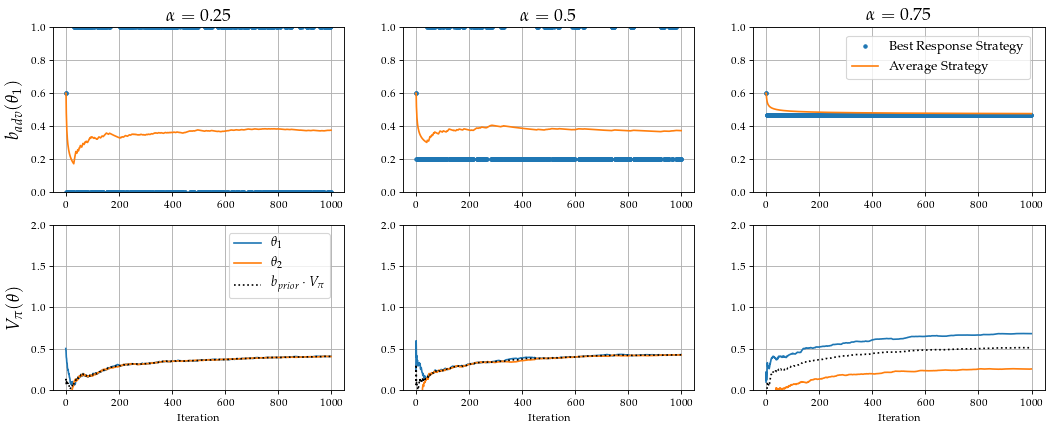

In [516]:
uct_belief_np = np.array(uct_belief_curves)
uct_br_belief_np = np.array(uct_br_belief_curves)
uct_avg_belief_np = np.array(uct_avg_belief_curves)
uct_np_model_vals = np.array(uct_model_value_curves)
uct_performance_on_bavg = np.sum(np_model_vals*uct_avg_belief_np, axis=2)
uct_performance_on_prior = belief[0]*uct_np_model_vals[:,:,0] + belief[1]*uct_np_model_vals[:,:,1]

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

for i,alpha_i in enumerate([0, 2, 4]):
    plt.subplot(2,3,i+1)
    plt.plot(uct_br_belief_np[alpha_i,:,0], label='Best Response Strategy', linestyle='None', marker='.')
    plt.plot(uct_avg_belief_np[alpha_i,:,0], label='Average Strategy')
    #plt.plot(belief_np[alpha_i,:,0], label='Mixed strategy', linestyle=':')
    
    if i == 0:
        plt.ylabel(r"$b_{adv}(\theta_1)$", fontsize=16)
    plt.title(r"$\alpha ="+str(alpha_vals[alpha_i])+r"$", fontsize=16)
    if i == 2:
        plt.legend(fontsize=12, bbox_to_anchor=(0.95, 0.95), loc=1,
                   ncol=1, borderaxespad=0.)
    plt.ylim([0,1])
    plt.grid(True)
    
    plt.subplot(2,3,3+i+1)
    for j in range(N_params):
        plt.plot(uct_np_model_vals[alpha_i,:,j], label=r"$\theta_" + str(j+1) + r"$")
    plt.plot(uct_performance_on_prior[alpha_i,:], label=r"$b_{prior} \cdot V_\pi$", linestyle=':', color='k')
    #plt.plot(performance_on_bavg[alpha_i,:], label=r"$\bar{b}_{adv} \cdot V_\pi$")
    
    if i == 0:
        plt.ylabel(r"$V_\pi(\theta)$", fontsize=16)
    if i == 0:
        plt.legend(fontsize=12, bbox_to_anchor=(0.95, 0.95), loc=1,
                   ncol=1, borderaxespad=0.)
    plt.xlabel('Iteration')
    plt.ylim([0,2])
    plt.grid(True)
plt.show()

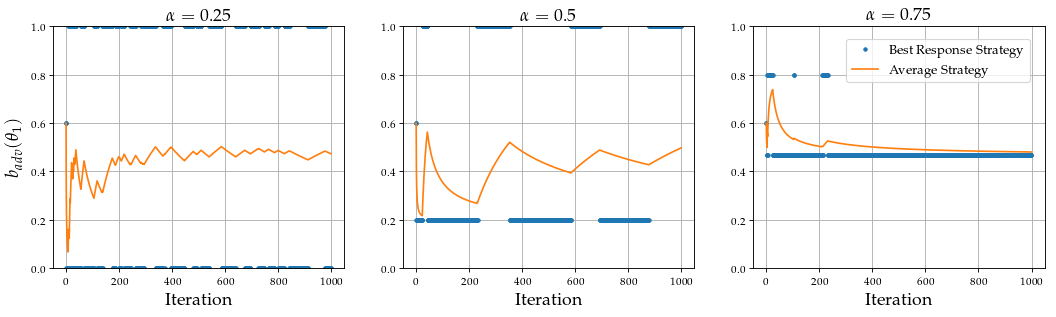

In [534]:
mkv_belief_np = np.array(mkv_belief_curves)
mkv_br_belief_np = np.array(mkv_br_belief_curves)
mkv_avg_belief_np = np.array(mkv_avg_belief_curves)

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

for i,alpha_i in enumerate([0, 2, 4]):
    plt.subplot(1,3,i+1)
    plt.plot(mkv_br_belief_np[alpha_i,:,0], label='Best Response Strategy', linestyle='None', marker='.')
    plt.plot(mkv_avg_belief_np[alpha_i,:,0], label='Average Strategy')
    #plt.plot(belief_np[alpha_i,:,0], label='Mixed strategy', linestyle=':')
    
    if i == 0:
        plt.ylabel(r"$b_{adv}(\theta_1)$", fontsize=16)
    plt.xlabel("Iteration", fontsize=16)
    plt.title(r"$\alpha ="+str(alpha_vals[alpha_i])+r"$", fontsize=16)
    if i == 2:
        plt.legend(fontsize=12, bbox_to_anchor=(0.95, 0.95), loc=1,
                   ncol=1, borderaxespad=0.)
    plt.ylim([0,1])
    plt.grid(True)
plt.show()